# Ethernet Packet Calculations

## Calculate Size of Var Packets Content

In [1]:
def print_size_format(name, bit_size, bits_per_pixel):
  print("{0} = {1:6}bits {2:6}bytes {3:6}px".format(name, bit_size, bit_size/8, bit_size/bits_per_pixel))
  print("    * {0:6} x 256bit (Memory bus access)".format(bit_size/256))
  print("    * {0:6} x  32bit (TSE bus access)".format(bit_size/32))
  print("    * {0:6} x   8bit (Byte access (payload word in Frame_list.txt))".format(bit_size/8))
def calc_VarEthernetPackets(start_x, start_y, width_x, height_y):
  bits_per_pixel = 4
  # calc line size
  line_size    = (width_x * bits_per_pixel) # in bit
  # check line_size multiple of 256bit
  if not (line_size % 256 == 0):
    print("ERROR: width_x ({}px) is not a multiple of 256bit".format(width_x))
    return
  # calc payload size
  payload_size = line_size * height_y # in bit
  if not (payload_size % 256 == 0):
    print("ERROR: payload size (width_x*heigth_y) ({}px*{}px)  is not a multiple of 256bit".format(width_x, height_y))
    return
  # Print result
  print_size_format("line_size", line_size, bits_per_pixel)
  print_size_format("payload_size", payload_size, bits_per_pixel)
  print("")


In [2]:
start_x  = 1   # px
start_y  = 1   # px
width_x  = 256 # px
height_y = 4   # px
#calc_VarEthernetPackets(start_x, start_y, width_x, height_y)

width_x  = 64  # px
height_y = 3   # px
#calc_VarEthernetPackets(start_x, start_y, width_x, height_y)

start_x  = 0   # px
start_y  = 256 # px
width_x  = 512 # px
height_y = 4   # px
calc_VarEthernetPackets(start_x, start_y, width_x, height_y)

line_size =   2048bits  256.0bytes  512.0px
    *    8.0 x 256bit (Memory bus access)
    *   64.0 x  32bit (TSE bus access)
    *  256.0 x   8bit (Byte access (payload word in Frame_list.txt))
payload_size =   8192bits 1024.0bytes 2048.0px
    *   32.0 x 256bit (Memory bus access)
    *  256.0 x  32bit (TSE bus access)
    * 1024.0 x   8bit (Byte access (payload word in Frame_list.txt))



## Var Data Frame to image conversion
Copy in variable `eth_data` all bits from Wireshark
* application_header -> Right Click -> Copy -> Bytes -> HexStream

In [3]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def eth_vardata_analysis(eth_packets_data = [], verbose = False):
  eth_header_def = [[0, 1, "VarData Version", ""],
                    [1, 1, "VarData Flags", ""],
                    [2, 2, "VarData Command", ""],
                    [4, 4, "VarData Session ID", ""],
                    [8, 4, "VarData Frame Number", ""],
                    [12, 4, "Start X", ""],
                    [16, 4, "Start Y", ""],
                    [20, 4, "Width X", ""],
                    [24, 4, "Height Y", ""],
                    [28, 999999, "Raw VarData", ""]
  ]
  # create output directory
  img_path   = "Ethernet_Variable_Data_Packet/Out/" # Relative path
  images_arr = [] # empty array for images
  dir = os.path.dirname(img_path)
  if not os.path.exists(dir):
    os.makedirs(dir)
  
  for p in range(len(eth_packets_data)):
    # Clean bmp header
    eth_packets_data[p] = eth_packets_data[p].replace(" ", "")
    
    # Split bmp header in byte pieces
    i = 0
    eth_data_bytes = []
    while i < len(eth_packets_data[p])-1:
      eth_data_bytes.append(eth_packets_data[p][i] + eth_packets_data[p][i+1])
      #if i < eth_header_def[9][0]:
      #  eth_data_bytes.append(eth_packets_data[p][i] + eth_packets_data[p][i+1])
      #else
      #  eth_data_bytes.append(eth_packets_data[p][i+1] + eth_packets_data[p][i])
      i += 2
  
    # Get Header Fields according to spec
    for i in range(0, len(eth_data_bytes)):
      for j in range(0, len(eth_header_def)):
        if i >= eth_header_def[j][0] and i < (eth_header_def[j][0] + eth_header_def[j][1]):
          #print("Field {0} found".format(eth_header_def[j][2]))
          if eth_header_def[j][2] == "Raw VarData":
            eth_header_def[j][3] = eth_header_def[j][3] + eth_data_bytes[i]
          else:
            eth_header_def[j][3] = eth_data_bytes[i] + eth_header_def[j][3]
  
    # Analysis
    # Get Fields
    start_x = 0
    start_y = 0
    width_x = 0
    height_x = 0
    if verbose:
      print("Field name                              | Hex Value  | Decimal Value |")
      print("----------------------------------------+------------+---------------+")
    for field in eth_header_def:
      if field[2] == "Start X":
          start_x = int(field[3],16)
      elif field[2] == "Start Y":
          start_y = int(field[3],16)
      elif field[2] == "Width X":
          width_x = int(field[3],16)
      elif field[2] == "Height Y":
          height_y = int(field[3],16)
      elif field[2] == "Raw VarData":
          vardata = field[3]
      if verbose:
        print("Field {0:33} | {1:10} | {2:13} |".format(field[2], field[3], int(field[3],16)))
    print("Frame {0:02}: start_x={1}, start_y={2}px, width_x={3}px, height_y={4}px, framelength={5}px={6}byte".format(p, start_x, start_y, width_x, height_y, len(vardata), len(vardata)/2))
    if verbose:
      print("Create empty image x = {}, y = {}".format(width_x, height_y))
    images_arr.append(Image.new( 'RGB', (width_x,height_y), "white")) # create a new black image
    pixels = images_arr[p].load() # create the pixel map
    for y in range(0, images_arr[p].size[1], 1):
      for x in range(0, images_arr[p].size[0], 1):
        coord_data = y*(width_x)+(x)
        #if not(coord_data >= len(vardata)):
        if vardata[coord_data] == "1":
          images_arr[p].putpixel((x,y), (255, 255, 255))
        else:
          images_arr[p].putpixel((x,y), (0, 0, 0))
    image_path = "{0}{1:03}_{2}_{3}_{4}_{5}.png".format(img_path, p, start_x, start_y, width_x, height_y)
    images_arr[p].save(image_path)
    if verbose:
      print("Images saved as: {}".format(image_path))
    
    
    # Cleanup eth_header_def
    for eth_header_field in eth_header_def:
      eth_header_field[3] = ""
  
  # Get all image data and display it splitted
  f, axarr = plt.subplots(len(images_arr)+2, sharex=True)
  axarr[0].set_title('Var Data Image split in frames')
  for i in range(len(images_arr)):
    axarr[i].imshow(np.asarray(images_arr[i]))
    axarr[i].axis('off')
    
  # Combine all images to one Var Data image
  var_data_image = Image.new( 'RGB', (width_x,height_y*len(images_arr)), "white")
  image_path = "{0}VarDataImage.png".format(img_path)
  for i in range(len(images_arr)):
    var_data_image.paste(images_arr[i], (0, height_y*i))
  var_data_image.save(image_path)
  print("Images saved as: {}".format(image_path))
  axarr[len(images_arr)+1].set_title('Var Data Complete Image')
  axarr[len(images_arr)+1].imshow(np.asarray(var_data_image))
  axarr[len(images_arr)+1].axis('off')
  axarr[len(images_arr)].axis('off')

Frame 00: start_x=0, start_y=256px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 01: start_x=0, start_y=260px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 02: start_x=0, start_y=264px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 03: start_x=0, start_y=268px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 04: start_x=0, start_y=272px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 05: start_x=0, start_y=276px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 06: start_x=0, start_y=280px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 07: start_x=0, start_y=284px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 08: start_x=0, start_y=288px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 09: start_x=0, start_y=292px, width_x=512px, height_y=4px, framelength=2048px=1024.0byte
Frame 10: start_x=0, start_y=296px, width_x=512px,

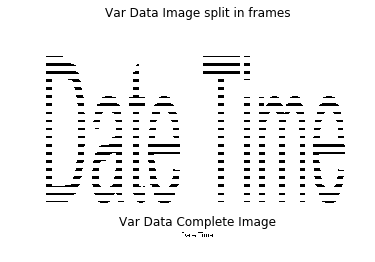

In [4]:
eth_data_packet = []
eth_data_packet.append("0100100005000000010000000000000000010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000020000000000000004010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000030000000000000008010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("010010000500000004000000000000000c010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000050000000000000010010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000011111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000060000000000000014010000000200000400000011111111111111111111111110000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000011111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000000000001111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000011111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000070000000000000018010000000200000400000011111111111111111111111110000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000011111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000000000001111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000011111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("010010000500000008000000000000001c010000000200000400000011111111111111111111111110000000001111111111111111111111110000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111110000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000090000000000000020010000000200000400000011111111111111111111111110000000001111111111111111111111111111111110000000000011111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111110000000000011111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111110000000000011111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111100000000000111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("01001000050000000a0000000000000024010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111110000000000011111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111100000000001111111111111111111111111111111110000000000001111111111111111111111111111111000000000111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111111111111111111000000001111111111111111111111000000000111111111111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111100000000001111111111111111111111111111000000000000000000000111111111111111111110000000000000000000000001111111111111111111111000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000001111111110000000000000011111111111111110000000000000001111111111111111111111111111111111110000000000000000001111111111111111111111111111111111111111111111")
eth_data_packet.append("01001000050000000b0000000000000028010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111100000000001111111111111111111111111000000000000000000000000001111111111111111110000000000000000000000001111111111111111111000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000001111110000000000000000000111111111111000000000000000000011111111111111111111111111111111000000000000000000000011111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111000000000011111111111111111111111000000000000000000000000000000111111111111111100000000000000000000000011111111111111111000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000011111000000000000000000000111111111100000000000000000000011111111111111111111111111111000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111000000000111111111111111111111000000000000000000000000000000000111111111111111000000000000000000000000111111111111111100000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000111100000000000000000000000111111100000000000000000000000011111111111111111111111111100000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111110000000000111111111111111111100000000000000000000000000000000000111111111111110000000000000000000000001111111111111110000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000001100000000000000000000000000111110000000000000000000000000011111111111111111111111110000000000000000000000000000001111111111111111111111111111111111111111")
eth_data_packet.append("01001000050000000c000000000000002c010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111110000000000111111111111111111000000000000000000000000000000000000011111111111110000000000000000000000001111111111111100000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000001100000000000000000000000000011100000000000000000000000000001111111111111111111111000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111100000000001111111111111111100000000000000001111110000000000000000111111111111100000000000000000000000011111111111110000000000000011111100000000000000011111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000010000000000000000000000000000111000000000000000000000000000011111111111111111111100000000000000011111100000000000000111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111100000000011111111111111111000000000001111111111111110000000000000111111111111111111000000000111111111111111111111000000000000111111111111000000000000111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000000000000111111111000000000000100000000011111111000000000000011111111111111111111000000000000111111111111000000000000111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111100000000000111111111111111111000000000001111111111111111110000000001111111111111111111100000000000011111111111111100000000000111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000000000111111111111000000000000000000011111111111100000000000111111111111111111100000000000111111111111111100000000000111111111111111111111111111111111111")
eth_data_packet.append("01001000050000000d0000000000000030010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111100000000001111111111111111111100000000001111111111111111110000000001111111111111111111000000000001111111111111111110000000000011111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000000001111111111111110000000000000001111111111111110000000000111111111111111111000000000001111111111111111110000000000011111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111110000000000111111111111110000000000111111111111111111111100000000001111111111111111100000000011111111111111111110000000000111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000000000111111111111111100000000000000111111111111111110000000000111111111111111110000000000111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111100000000001111111111111100000000011111111111111111111111000000000011111111111111111000000000111111111111111111000000000011111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000000011111111111111111100000000000011111111111111111110000000001111111111111111000000000011111111111111111111110000000000111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111110000000000111111111111111111111111000000000111111111111111110000000001111111111111111110000000001111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000001111111111111111111000000000000111111111111111111100000000011111111111111110000000001111111111111111111111110000000001111111111111111111111111111111111")
eth_data_packet.append("01001000050000000e0000000000000034010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111110000000001111111111111111111111111000000000111111111111111110000000001111111111111111100000000001111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000001111111111111111111000000000001111111111111111111100000000011111111111111100000000001111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111110000000000111111111111100000000011111111111111111111111110000000001111111111111111100000000011111111111111111000000000111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000000111111111111111111110000000000011111111111111111111000000000111111111111111000000000111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111100000000001111111111111111000001111111111111111111111111100000000011111111111111111000000000111111111111111110000000001111111111111111111111111110000000011111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000001111111111111111111110000000001111111111111111111110000000001111111111111100000000001111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111000000000111111111111111110000000001111111111111111000000000011111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000011111111111111111111100000000011111111111111111111100000000011111111111111000000000111111111111111111111111111100000000111111111111111111111111111111111")
eth_data_packet.append("01001000050000000f0000000000000038010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111111111000000000111111111111111110000000001111111111111111000000000111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111100000000011111111111111000000000111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111110000000000111111111111111111111111111111111111111111111110000000001111111111111111100000000011111111111111110000000001111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111110000000001111111111111111111111111111000000000111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111100000000001111111111111111111111111111111111111111111111000000000011111111111111111000000000111111111111111100000000011111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111100000000011111111111111111111111111110000000001111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111111111111111111111111111111100000000000000111111111111111110000000001111111111111111000000000111111111111111111111111111110000000011111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000000111111111111111111111111111100000000011111111111111111111111111111111")
eth_data_packet.append("010010000500000010000000000000003c010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111111000000000011111111111111111111111111111111111110000000000000000000111111111111111110000000001111111111111110000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111110000000000111111111111111111111111111110000000000000000000000000001111111111111111100000000011111111111111100000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111100000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111100000000001111111111111111111111110000000000000000000000000000000011111111111111111000000000111111111111111000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111111000000000111111111111111111111100000000000000000000000000000000000111111111111111110000000001111111111111110000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000000000000000000000000000000000000000000001111111111111111111111111111111")
eth_data_packet.append("0100100005000000110000000000000040010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111110000000000111111111111111111110000000000000000000000000000000000000111111111111111110000000001111111111111110000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111100000000001111111111111111110000000000000000000000000000010000000001111111111111111100000000011111111111111100000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111100000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111111000000000011111111111111111000000000000000000000000001111100000000011111111111111111000000000111111111111111000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111110000000000111111111111111100000000000000000000000111111111000000000111111111111111110000000001111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000120000000000000044010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111100000000001111111111111111000000000000000000111111111111111000000000111111111111111110000000001111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111111000000000011111111111111110000000000000111111111111111111110000000001111111111111111100000000011111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111110000000000111111111111111000000000000111111111111111111111100000000011111111111111111000000000111111111111111000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111111000000000011111111111111100000000000111111111111111111111111000000000111111111111111110000000001111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111110000000000111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000130000000000000048010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111111000000000011111111111111100000000001111111111111111111111111000000000111111111111111110000000001111111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111111100000000000111111111111111000000000011111111111111111111111110000000001111111111111111100000000011111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111110000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111111111000000000011111111111111110000000001111111111111111111111111100000000011111111111111111000000000111111111111111100000000001111111111111111111111111110011111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111100000000011111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111111100000000000111111111111111000000000011111111111111111111111110000000000111111111111111110000000001111111111111111000000000011111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111000000000011111111111111111111111111100000000011111111111111111111111111111111")
eth_data_packet.append("010010000500000014000000000000004c010000000200000400000011111111111111111111111110000000001111111111111111111111111111111111000000000001111111111111111000000000011111111111111111111111110000000000111111111111111110000000001111111111111111100000000011111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111000000000011111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111111111100000000000011111111111111110000000000111111111111111111111111100000000001111111111111111100000000011111111111111111000000000011111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111111000000000011111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111000000000111111111111111111111111111111110000000000001111111111111111100000000001111111111111111111111110000000000011111111111111111000000000111111111111111111000000000111111111111111111111111100000000001111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111110000000000111111111111111111111111000000000011111111111111111111111111111111111111111111111111111111110000000001111111111111111111111111111111000000000000111111111111111111000000000011111111111111111111111000000000000111111111111111110000000001111111111111111110000000000111111111111111111111110000000000111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111110000000000111111111111111111111110000000000111111111111111111111111111111111")
eth_data_packet.append("0100100005000000150000000000000050010000000200000400000011111111111111111111111110000000001111111111111111111111111111100000000000000111111111111111111000000000011111111111111111111110000000000000111111111111111110000000001111111111111111110000000000011111111111111111111100000000000111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111110000000000011111111111111111111100000000001111111111111111111111111111111111111111111111111111111111100000000011111111111111111111111111000000000000000011111111111111111111000000000011111111111111111111000000000000001111111111111111100000000001111111111111111110000000000011111111111111111110000000000011111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111111110000000000011111111111111111110000000000011111111111111111111111111111111111111111111111111111111111000000000111111111111111111110000000000000000000001111111111111111111110000000000011111111111111111100000000000000011111111111111111000000000011111111111111111110000000000011111111111111111000000000000111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111111100000000000011111111111111111000000000001111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000111111111111111111111100000000000011111111111111100000000000000000011111111111111110000000000000110001111111111100000000000001111111111111000000000000011111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111111100000000000001111111111111000000000000011111111111111111111111111111111111")
eth_data_packet.append("0100100005000000160000000000000054010000000200000400000011111111111111111111111110000000000000000000000000000000000000000000000001111111111111111111111110000000000000111111111110000000000000000000011111111111111111000000000000000001111111111110000000000000001111111000000000000000111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111111110000000000000001111111000000000000000111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000111111111111111111111111110000000000000000000000000000000001000000000111111111111111110000000000000000011111111111110000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111111111110000000000000000000000000000000000011111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000000000000000111111111111111111111111111100000000000000000000000000000000110000000001111111111111111100000000000000000111111111111110000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111111111110000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000111111111111111111111111111111100000000000000000000000000000111110000000011111111111111111100000000000000001111111111111110000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111111111110000000000000000000000000000000111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000170000000000000058010000000200000400000011111111111111111111111110000000000000000000000000000000000000000011111111111111111111111111111111110000000000000000000000000001111110000000001111111111111111110000000000000001111111111111111100000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111000000000011111111111111111111111111111100000000011111111111111000000000111111111111111111111100000000011111111111111111111110000000011111111111111111111111100000000000000000000000000011111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000111111111111111111111111111111111111111000000000000000000000001111111100000000011111111111111111110000000000000001111111111111111110000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111110000000000111111111111111111111111111111000000000111111111111110000000001111111111111111111111000000000111111111111111111111100000000111111111111111111111111100000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111000000000000000000000000000000000111111111111111111111111111111111111111111111100000000000000000001111111111100000000011111111111111111111000000000000011111111111111111111000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111100000000001111111111111111111111111111110000000001111111111111100000000011111111111111111111110000000001111111111111111111111000000001111111111111111111111111110000000000000000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000000111111111111111111111111111111111111111111111110000000111111111111111111111111110000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000111111111111111111111111111111111111111111111111")
eth_data_packet.append("010010000500000018000000000000005c010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_data_packet.append("0100100005000000190000000000000060010000000200000400000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111")
eth_vardata_analysis(eth_data_packet, False)

Frame 00: start_x=2496, start_y=385px, width_x=128px, height_y=128px, framelength=16384px=8192.0byte
Images saved as: Ethernet_Variable_Data_Packet/Out/VarDataImage.png


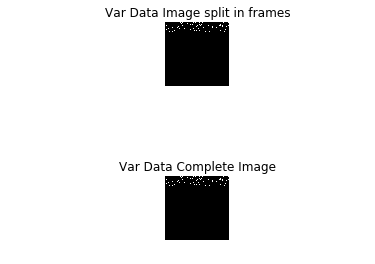

In [5]:
eth_data_packet = []
eth_data_packet.append("010010000700000001000000c00900008101000080000000800000000000000000000000001000000010000000000000000000001000100000010000000010010010010000000100010000000000010100100000000000010001000000000000000010000000000000000001000100000000001000100010010001001000010000010000000000000000000000000000100000000000010000001001001000000000000010000100100010000000000000000000010000100000100000100001000001000000000000000000000001000010100000000001010000100000000000000000000000000000000001000000000001000000100010100010100010001010000000000000000000100000001010000000000000000000100000000010000100000010000100100010000010000000000100100000100010001001001000001001000000000000000000000000001010100000000000010000100000000000001000001000000000000000000000000000000100110010001000100100010000000000000000000000000000000000000100000000000000100000000001000000000000000100100010000010000000010100010001001000100110010001000000000000000000001000000000010000010000000000010000010010000000000010001000000000000100001000000000100000000010100100000100000000000000010000000000000000000001010001000000000001000000000000000100000000000001000010000000000001000000000000000001001000000000000000000000000010000000000010000001000100000010010000000000001000000010001001000010000000000000000000000000000001001000000000000000000000000000010000100000000000000100000001000000000000100000000100000000000000000010010000000000000000000000000000100000000000000000000000000000000000000000000000000000000100000010000000000100000010010000100000000000000000000010000000000000100000000001000000000000000001000000010000000000100000000000100000000000100100000100000000000000100000000000000000100100000000000001000000000000000000000000100000000000000000000000000000000000000001000000000000000000100100000000010000000000100010010000000001000000000000001000001000000000000000000000000000100000000000000000000000000100100100000000001000100000000000010001000100100000100000000000000000000000000000000000000000000000000000000000000001000000001000000000001000100000000000000000000001001000100000000000000000000000000000000000000000000000001000000000000100000000000001000100000000000000000000001000100000000010000000100010000000000000000000000000000000000000000000000000100000000000000000000000000000000010010010001000000000000000000000001010101001000100000100000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000001000000000000000010000100100000000000000000000000000010000000000000000000000100000000000100000000010010010010000100010000000100000000000000000000010000000000000000000000010010000000100100000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000")
eth_vardata_analysis(eth_data_packet, False)

In [6]:
# encoding=utf8
# reading from an saved trace file
import pyshark
cap = pyshark.FileCapture('Ethernet_Variable_Data_Packet/test_16_1060_1.pcap')
for pkt in cap:
    print(pkt)
    

ModuleNotFoundError: No module named 'pyshark'